# A Less Basic Example of Time Series Analysis Using Bayesian Methods

Real-life time series are often influenced by multiple external factors that can significantly alter their behavior. 

On October 7, 2023, a devastating attack by Hamas on Israel resulted in the tragic loss of over 1,300 lives in a single day, thousands more injured, and 250 people abducted, all in a country of just 9 million people. A bloody war ensued and is still ongoing (as of Sep 2023). This event had a profound impact on the lives of all the Israelis, Palestinians, and Lebanese. 

In this notebook, we will use the number of Hebrew-language podcast episodes published per week as a case study to demonstrate how Bayesian statistics can be employed to model the impact of such external events on time series data.


I acknowledge that this workshop uses a tragic event to teach statistical concepts, and I hope that the knowledge gained here can contribute to better understanding and, ultimately, to a more peaceful future.

-- Boris Gorelik

 

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from plot_utils import MY_COLORS, plot_data_with_predictions, plot_time_series

The data below contains the number of Hebrew-language podcast episodes published per week. To obtain this data, I used the [Podcast Index](https://podcastindex.org) database to extract the titles and descriptions of all tracked podcasts worldwide. I then used language detection models to identify the podcast languages and RSS links to count how many episodes were published each week.

Originally, the intent was to explore the effect of several external events on the number of episodes produced in different languages:
- Russian invasion of Georgia in 2008
- Russian annexation of Crimea in 2014
- Russian invasion of Ukraine in 2022
- And finally, the Hamas attack on Israel in 2023.

Due to time constraints, I will only explore the effect of the Hamas attack on Israel, but the aggregate data for Russian, Ukrainian, and Georgian languages is available in the data folder.

In [2]:
df_episodes = pd.read_csv(
    "data/episodes_per_week_he.csv", parse_dates=["week_start"]
).set_index("week_start")
df_episodes.head()

,episode_count
week_start,
2007-12-30,1
2008-01-06,4
2008-01-13,1
2008-01-20,2
2008-01-27,4


<Axes: title={'center': 'Hebrew-language podcast episodes per week'}>

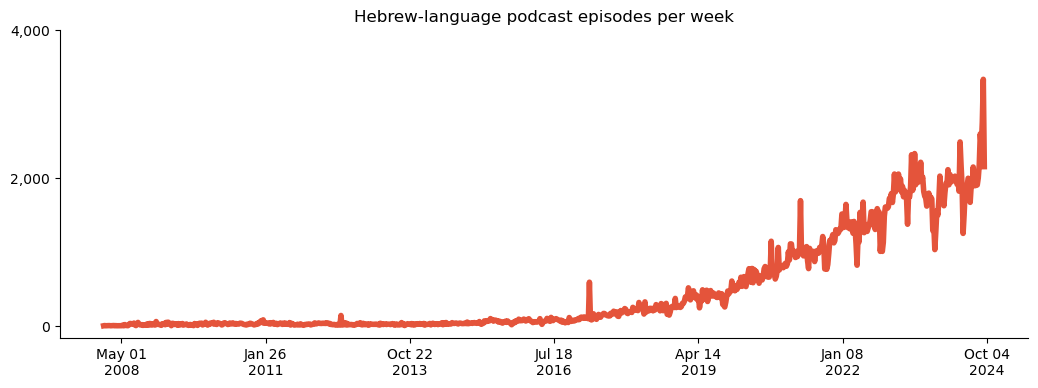

In [3]:
plot_time_series(
    df_episodes.index,
    df_episodes.episode_count,
    plot_type="line",
    title="Hebrew-language podcast episodes per week",
)

In [4]:
df_2023 = df_episodes.loc["2023-04-01":"2024-02-01"].copy()
date_reference = pd.to_datetime("2023-10-07")
weeks_since_reference = (df_2023.index - date_reference).days // 7 + 1
df_2023["weeks_since_reference"] = weeks_since_reference
df_2023

,episode_count,weeks_since_reference
week_start,,
2023-04-02,1374,-26
2023-04-09,1771,-25
2023-04-16,1743,-24
2023-04-23,1881,-23
2023-04-30,2314,-22
2023-05-07,1831,-21
2023-05-14,1894,-20
2023-05-21,2330,-19
2023-05-28,1908,-18


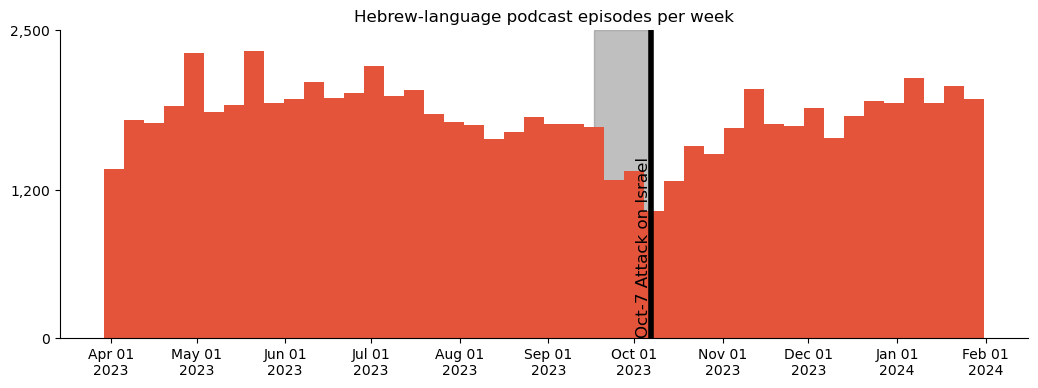

In [5]:
ax = plot_time_series(
    df_2023.index,
    df_2023.episode_count,
    plot_type="bar",
    title="Hebrew-language podcast episodes per week",
)
ax.axvline(date_reference, color="black", linestyle="-", lw=4)
ax.text(
    date_reference.date(),
    0,
    "Oct-7 Attack on Israel",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="right",
    fontsize=12,
)
gray_area = (pd.to_datetime("2023-09-17"), date_reference)
ax.axvspan(*gray_area, color="gray", zorder=-2, alpha=0.5)

The brutal Hamas attack on Israel occured on October 7, 2023. It is expected that this event will have a significant impact on the number of episodes produced by Hebrew-language podcasts immediately following the attack.  But why was there a decrease in the number of episodes produced during the approximately 20 days preceding the attack?   

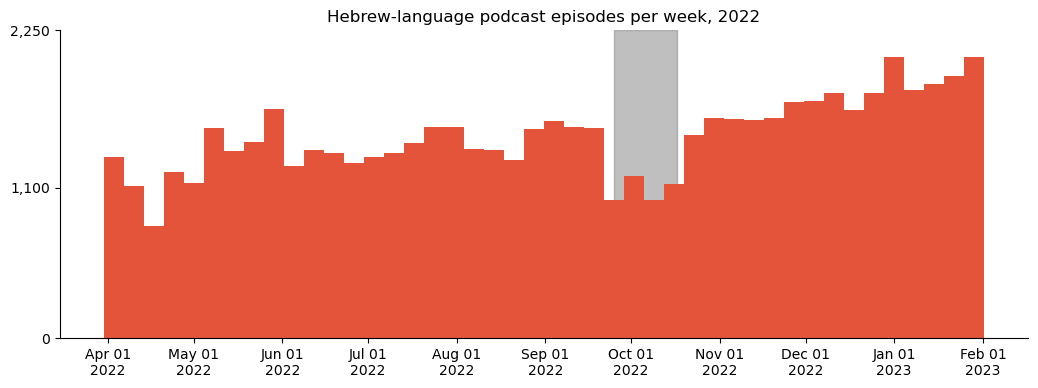

In [6]:
df_2022 = df_episodes.loc["2022-04-01":"2023-02-01"].copy()
ax = plot_time_series(
    df_2022.index,
    df_2022.episode_count,
    plot_type="bar",
    title="Hebrew-language podcast episodes per week, 2022",
)
gray_area = (pd.to_datetime("2022-09-25"), pd.to_datetime("2022-10-17"))
ax.axvspan(*gray_area, color="gray", zorder=-2, alpha=0.5)

```{note}
NOTE:
In the text below, I will use the term Tishrei. I deliberately don't explain it in the text to keep some
mystery. Future versions of this notebook will include a more detailed explanation.
```

In [7]:
within_tishrei = (df_2022.index >= pd.to_datetime("2022-09-25")) & (
    df_2022.index <= pd.to_datetime("2022-10-17")
)
df_2022["within_tishrei"] = within_tishrei.astype(int)

We will use pymc to estimate the effect Tishrei has on the number of episodes produced by Hebrew-language podcasts. 
Similarly to the previous example, we will use a Poisson distribution to model the number of episodes produced per week. We will use a single `lambda_baseline` parameter to model the number of episodes produced per week, and a `tishrei_effect` parameter to model the effect Tishrei has on the number of episodes produced per week, so that the number of episodes produced per week during Tishrei is `lambda_baseline * tishrei_effect`.

In [8]:
avrg_episodes_per_week = np.round(df_2022.episode_count.mean())
std_episodes_per_week = np.ceil(df_2022.episode_count.std())
avrg_episodes_per_week, std_episodes_per_week

(1475.0, 275.0)

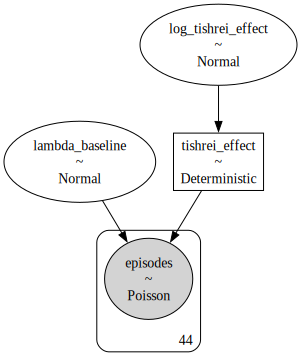

In [9]:
with pm.Model() as model_2022:
    lambda_baseline = pm.Normal(
        "lambda_baseline", mu=avrg_episodes_per_week, sigma=std_episodes_per_week
    )
    log_tishrei_effect = pm.Normal("log_tishrei_effect", mu=0, sigma=1)
    tishrei_effect = pm.Deterministic("tishrei_effect", pm.math.exp(log_tishrei_effect))
    lambda_tishrei = lambda_baseline * tishrei_effect
    lambda_ = pm.math.switch(within_tishrei, lambda_tishrei, lambda_baseline)
    episodes = pm.Poisson("episodes", lambda_, observed=df_2022.episode_count)

pm.model_to_graphviz(model_2022)

In [10]:
with model_2022:
    trace_2022 = pm.sample(2000, tune=2000, random_seed=42, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_baseline, log_tishrei_effect]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


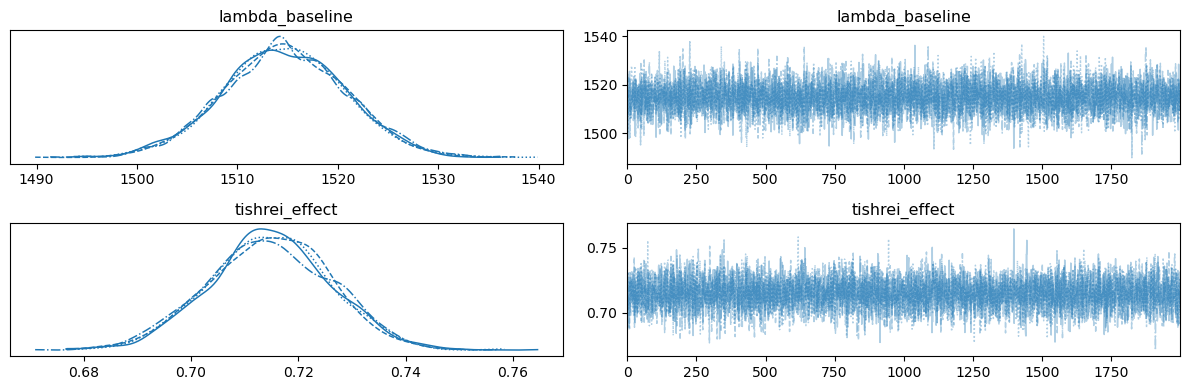

In [11]:
az.plot_trace(trace_2022, var_names=["lambda_baseline", "tishrei_effect"], compact=True)
plt.tight_layout()

<Axes: title={'center': 'tishrei_effect'}>

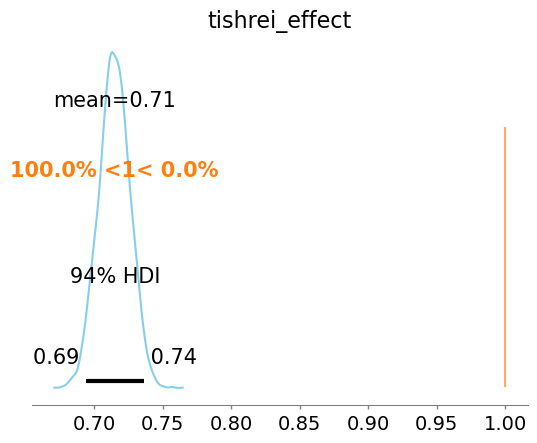

In [12]:
az.plot_posterior(trace_2022, var_names=["tishrei_effect"], ref_val=1, color="skyblue")

We can see that "Tishrei effect" reduces the rate of episodes produced by Hebrew-language podcasts by approximatly 30%. Let's now use this information to model the number of episodes produced in 2023.

Let's now plot the expected number of episodes produced per week in 2022, based on the model we estimated.

In [13]:
def generate_predictions(df, trace):
    """
    Generates predictions of expected episodes based on the given trace and DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data, including the 'within_tishrei' column.
    trace (arviz.InferenceData): Trace object containing the posterior samples.

    Returns:
    np.array: Array of predicted episode counts.
    """
    expected_episodes = np.zeros(len(df))

    # Loop over the rows of the DataFrame and compute expected episodes
    for i, (ix, row) in enumerate(df.iterrows()):
        lambda_baseline = trace.posterior["lambda_baseline"][:, i].mean()
        tishrei_effect = trace.posterior["tishrei_effect"][:, i].mean()
        within_tishrei = row["within_tishrei"]

        # Calculate effective lambda based on whether it's within tishrei
        if within_tishrei:
            lambda_effective = lambda_baseline * tishrei_effect
        else:
            lambda_effective = lambda_baseline

        expected_episodes[i] = lambda_effective

    return expected_episodes

In [14]:
expected_episodes_2022 = generate_predictions(df_2022, trace_2022)

Text(0.5, 1.0, 'Episodes per week in 2022')

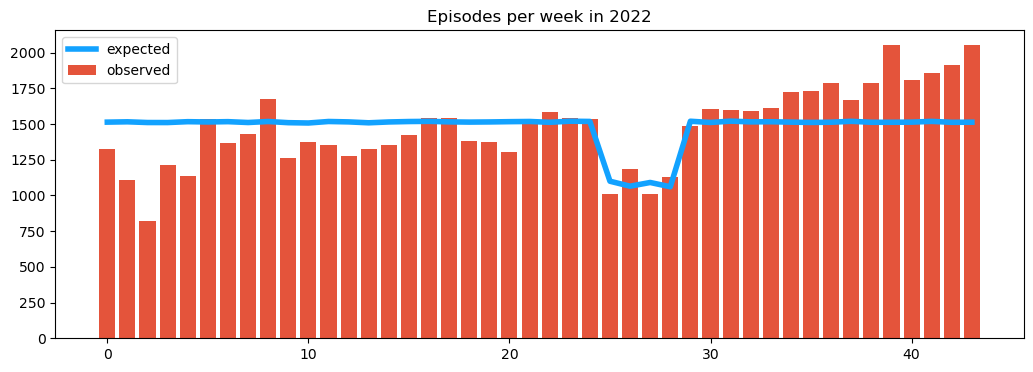

In [15]:
ax = plot_data_with_predictions(df_2022.episode_count, expected_episodes_2022)
ax.set_title("Episodes per week in 2022")

Let's go back to 2023 and model the number of episodes produced by Hebrew-language podcasts in 2023.

In [16]:
tishrei_2023 = (pd.to_datetime("2023-09-15"), pd.to_datetime("2023-10-08"))
df_2023["within_tishrei"] = (
    (df_2023.index >= tishrei_2023[0]) & (df_2023.index <= tishrei_2023[1])
).astype(int)

Now, we will use the `tishrei_effect` parameter we estimated in 2022 to model the number of episodes produced in 2023. Since the base episode rate is expected to change between the years, we want to learn the `lambda_baseline` parameter from the data. However, recall the saying "Today's posterior is tomorrow's prior." We can use the posterior distribution of the `lambda_baseline` parameter from 2022 as the prior distribution of the `lambda_baseline` parameter in 2023.

The rest of the modeling approach is the same as in 2022.

In [17]:
posterior_2022 = trace_2022.posterior
lambda_baseline_2022_mean = posterior_2022["lambda_baseline"].mean().values
lambda_baseline_2022_std = posterior_2022["lambda_baseline"].std().values
log_tishrei_effect_2022_mean = posterior_2022["log_tishrei_effect"].mean().values
log_tishrei_effect_2022_std = posterior_2022["log_tishrei_effect"].std().values


with pm.Model() as model_2023:
    # Use mean and standard deviation as prior parameters
    lambda_baseline = pm.Normal(
        "lambda_baseline", mu=lambda_baseline_2022_mean, sigma=lambda_baseline_2022_std
    )
    log_tishrei_effect = pm.Normal(
        "log_tishrei_effect",
        mu=log_tishrei_effect_2022_mean,
        sigma=log_tishrei_effect_2022_std,
    )
    tishrei_effect = pm.Deterministic("tishrei_effect", pm.math.exp(log_tishrei_effect))
    lambda_tishrei = lambda_baseline * tishrei_effect

    # Ensure that `df_2023.within_tishrei` is a boolean array of the same shape as `lambda_baseline`
    lambda_ = pm.math.switch(
        df_2023.within_tishrei.values, lambda_tishrei, lambda_baseline
    )

    # Define the observed data likelihood
    episodes = pm.Poisson("episodes", lambda_, observed=df_2023.episode_count)

    # Sampling from the model
    trace_2023 = pm.sample(2000, tune=2000, random_seed=42, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_baseline, log_tishrei_effect]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


Text([26], 0, 'Oct-7 Attack on Israel')

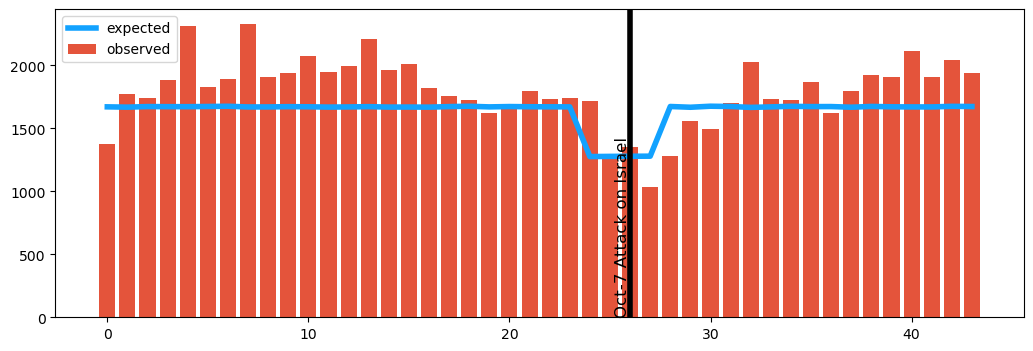

In [18]:
expected_episodes_2023 = generate_predictions(df_2023, trace_2023)
ax = plot_data_with_predictions(df_2023.episode_count, expected_episodes_2023)
ix = np.where(df_2023.weeks_since_reference.values == 0)[0]
ax.axvline(ix, color="black", linestyle="-", lw=4)
ax.text(
    ix,
    0,
    "Oct-7 Attack on Israel",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="right",
    fontsize=12,
)

Now, that we have a reasonable model for the Tishrey effect, we can also model the effect of the attack on the number of episodes produced by Hebrew-language podcasts. My hypothesis is that the reduction factor of the attack will start at some number `0 < attack_effect < 1` and will gradually increase to 1. We can model this using a logistic function.

Text(0, 0.5, 'reduction effect')

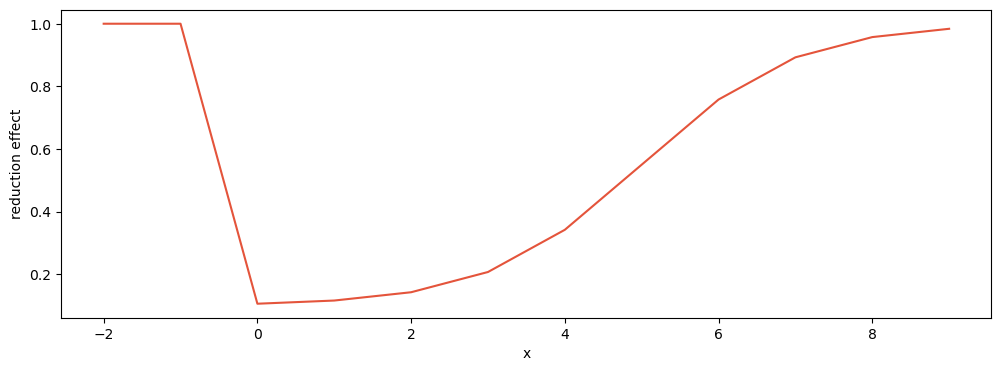

In [19]:
def logistic(x, y_min, rate, x_mid):
    y_max = 1.0
    ret = y_min + (y_max - y_min) / (1 + np.exp(-rate * (x - x_mid)))
    if np.isscalar(x):
        return 1.0 if x < 0 else ret
    ret[x < 0] = 1.0  # no reduction before the attack
    return ret


x = np.arange(-2, 10)
y = logistic(x, y_min=0.1, rate=1, x_mid=5)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x, y, color=MY_COLORS[0])
ax.set_xlabel("x")
ax.set_ylabel("reduction effect")

While `y_max` is most probably 1, we need initial guesses for `y_min` and `x_mid`

In [20]:
vals = df_2023.loc[df_2023.weeks_since_reference.isin([0, 1]), "episode_count"].values
log_attack_initial_effect_guess = np.log(vals[1] / vals[0])
log_attack_initial_effect_guess

-0.2725339694552604

We'l use `log_attack_effect_guess` as the initial guess for the `attack_effect` parameter. For `x_mid`, we'll use uniform prior between 1 and 10 weeks. For `rate`, we'll use a half-normal distribution with std of 2. We'll also use the `expected_episodes_2023` as the prior for the `lambda_baseline` parameter.

In [21]:
def pymc_compatible_logistic(x, y_min, rate, x_mid):
    y_max = 1.0
    logistic_curve = y_min + (y_max - y_min) / (1 + pm.math.exp(-rate * (x - x_mid)))
    return pm.math.switch(x < 0, 1.0, logistic_curve)  # Set value to 1.0 when x < 0

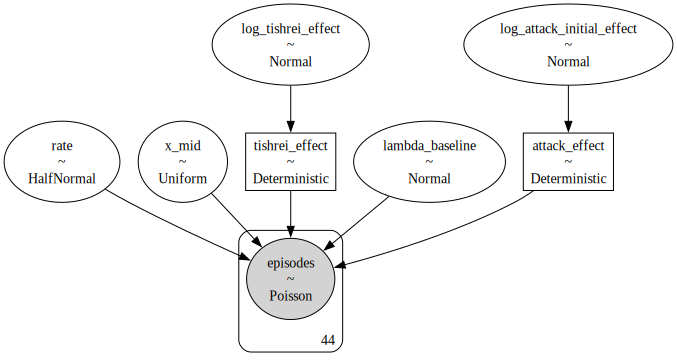

In [22]:
posterior_2023 = trace_2023.posterior
lambda_baseline_2023_mean = posterior_2023["lambda_baseline"].mean().values
lambda_baseline_2023_std = posterior_2023["lambda_baseline"].std().values
log_tishrei_effect_2023_mean = posterior_2023["log_tishrei_effect"].mean().values
log_tishrei_effect_2023_std = posterior_2023["log_tishrei_effect"].std().values

with pm.Model() as model_2023_attack:
    # Define priors using previous model's posteriors
    lambda_baseline = pm.Normal(
        "lambda_baseline", mu=lambda_baseline_2023_mean, sigma=lambda_baseline_2023_std
    )
    log_tishrei_effect = pm.Normal(
        "log_tishrei_effect",
        mu=log_tishrei_effect_2023_mean,
        sigma=log_tishrei_effect_2023_std,
    )
    tishrei_effect = pm.Deterministic("tishrei_effect", pm.math.exp(log_tishrei_effect))
    lambda_tishrei = lambda_baseline * tishrei_effect
    lambda_ = pm.math.switch(
        df_2023.within_tishrei.values, lambda_tishrei, lambda_baseline
    )

    # Attack effect parameters
    log_attack_initial_effect = pm.Normal(
        "log_attack_initial_effect", mu=log_attack_initial_effect_guess, sigma=0.5
    )
    attack_effect = pm.Deterministic(
        "attack_effect", pm.math.exp(log_attack_initial_effect)
    )
    rate = pm.HalfNormal("rate", sigma=2)
    x_mid = pm.Uniform("x_mid", lower=1, upper=10)

    # Generate attack effect curve using the PyMC-compatible logistic function
    attack_effect_curve = pymc_compatible_logistic(
        x=df_2023.weeks_since_reference.values,
        y_min=attack_effect,
        rate=rate,
        x_mid=x_mid,
    )

    # Include the attack effect in the model
    adjusted_lambda_ = lambda_ * attack_effect_curve

    # Likelihood of observed data
    episodes = pm.Poisson("episodes", adjusted_lambda_, observed=df_2023.episode_count)
pm.model_to_graphviz(model_2023_attack)

Look how complex the model is gradually becoming.

In [23]:
with model_2023_attack:
    trace_2023_attack = pm.sample(
        2000, tune=2000, random_seed=42, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_baseline, log_tishrei_effect, log_attack_initial_effect, rate, x_mid]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


<Axes: title={'center': 'attack_effect'}>

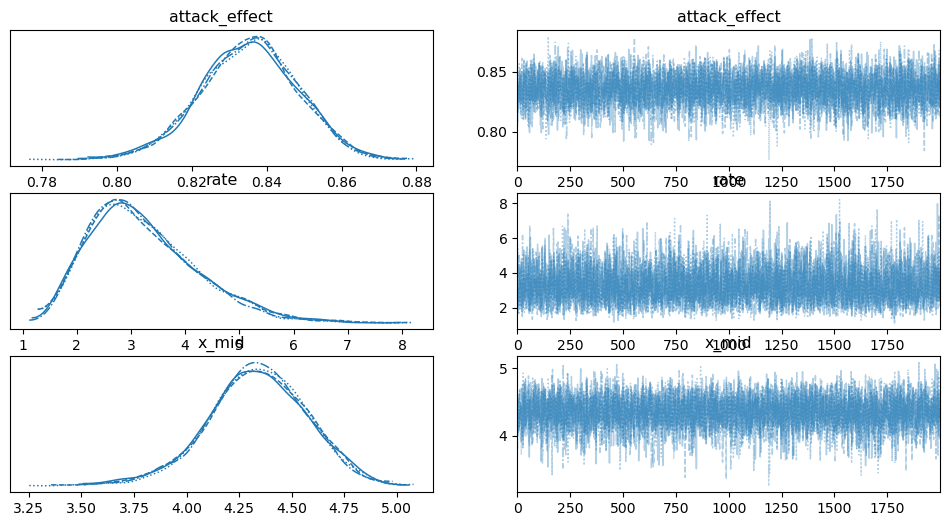

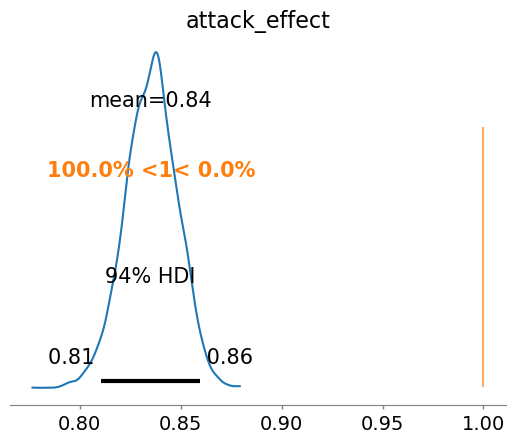

In [24]:
az.plot_trace(
    trace_2023_attack, var_names=["attack_effect", "rate", "x_mid"], compact=True
)
az.plot_posterior(trace_2023_attack, var_names=["attack_effect"], ref_val=1)

The attack reduced the number of episodes produced by Hebrew-language podcasts by approximately 15%, which is much less than one would expect. Let's plot the expected number of episodes produced per week in 2023, based on the model we estimated.

In [25]:
def generate_predictions_attack_effect(trace, df):
    lambda_baseline_values = trace.posterior["lambda_baseline"].values.flatten()
    tishrei_effect_values = trace.posterior["tishrei_effect"].values.flatten()
    attack_initial_effect_values = trace.posterior[
        "log_attack_initial_effect"
    ].values.flatten()
    rate_values = trace.posterior["rate"].mean(dim=("chain", "draw")).values.flatten()
    x_mid_values = trace.posterior["x_mid"].mean(dim=("chain", "draw")).values.flatten()
    expected_episodes = np.zeros(len(df))
    for i, (ix, row) in enumerate(df.iterrows()):
        lambda_baseline = lambda_baseline_values
        tishrei_effect = tishrei_effect_values
        attack_effect = np.exp(attack_initial_effect_values[i])
        rate = rate_values
        x_mid = x_mid_values

        if row["within_tishrei"]:
            lambda_effective = lambda_baseline * tishrei_effect
        else:
            lambda_effective = lambda_baseline

        attack_effect_curve = logistic(
            x=row["weeks_since_reference"], y_min=attack_effect, rate=rate, x_mid=x_mid
        )
        lambda_adjusted = lambda_effective * attack_effect_curve
        expected_episodes[i] = lambda_adjusted.mean()

    return expected_episodes

Text([26], 0, 'Oct-7 Attack')

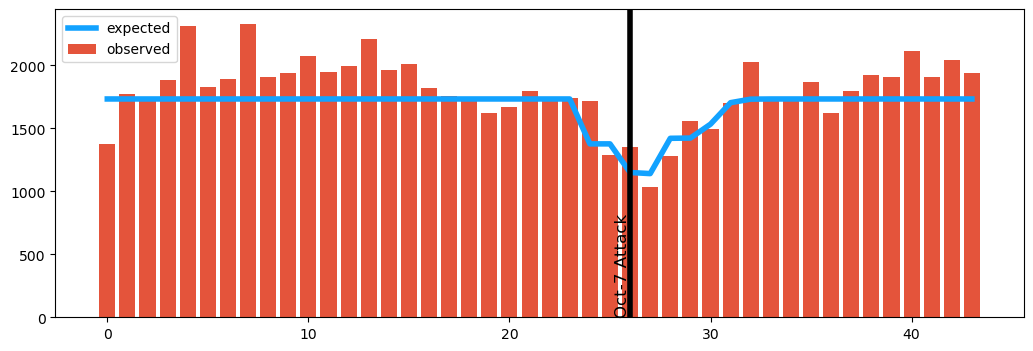

In [26]:
expected_episodes_2023_attack = generate_predictions_attack_effect(
    trace_2023_attack, df_2023
)
ax = plot_data_with_predictions(df_2023.episode_count, expected_episodes_2023_attack)
ix = np.where(df_2023.weeks_since_reference.values == 0)[0]
ax.axvline(ix, color="black", linestyle="-", lw=4)
ax.text(
    ix,
    0,
    "Oct-7 Attack",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="right",
    fontsize=12,
)